# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [14]:
# Load pickled data
import pickle
import os

data_folder = 'traffic-signs-data'
training_file = os.path.join(data_folder, 'train.p')
testing_file = os.path.join(data_folder, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [15]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [16]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

def visualize_dataset(features, labels, n_classes, histogram=True, overview=True):
    """
    Visualize the given features and labels.
    It shows a histogram of the distribution of classes and examples of the classes.
    :param features: List of evaluated features
    :param labels: List of evaluated labels
    :param histogram: Show histogram of class labels
    :param overview: Show overview on class labels
    """
    
    # Show the class label distribution in a histogram
    if histogram:
        # Create a histogram of training lables
        fig = plt.figure()
        n, bins, patches = plt.hist(labels, n_classes)

        plt.xlabel('Traffic Sign Classes')
        plt.ylabel('occurrences')
        plt.show()

    # Show an image of each traffic sign category
    if overview:
        fig = plt.figure()
        fig.suptitle('Overview Traffic Signs', fontsize=16)

        # Create an overview of trafic sign classes
        pltRows = 5
        pltCols = (n_classes / pltRows) + 1
        for el in range(n_classes):
            for i in range(0, len(labels)):
                if (labels[i] == el):
                    plt.subplot(pltRows, pltCols, el + 1)
                    fig = plt.imshow(features[i, :, :, :], interpolation='nearest')
                    fig.axes.get_xaxis().set_visible(False)
                    fig.axes.get_yaxis().set_visible(False)
                    break
        plt.show()

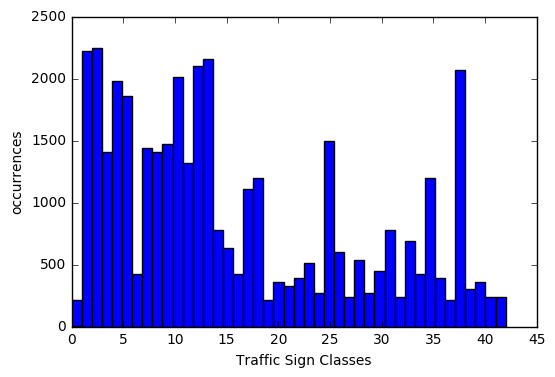

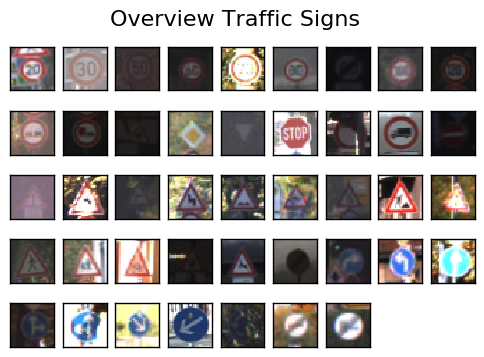

In [17]:
visualize_dataset(X_train, y_train, n_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [18]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import cv2
import numpy as np

def pre_process_image(image):
    """
    Convert image to YUV space and normalize results
    :return: Normalized image in yuv space
    """
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    return (yuv / 255. * 2.) - 1.

all_processed_training_features = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype=np.float32)
test_features = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype=np.float32)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [19]:
### The image was first converted to YUV color space. The Y channel 
### Afterwards the images are normalized around [-1, 1] as NN work better with a mean around 0.

In [35]:
### Generate data additional data
import scipy.interpolate as interpolate 

def shift_and_rotate_image(img, shift=(0, 0), rotation=0, scale=1.0):
    """
    Shift and rotate image by given coefficients
    :param img: Input image
    :param shift: Tuple for shift in x and y direction
    :param rotation: Rotation in deg
    :param scale: Scaling that should be applied to the image
    :return: Shifted and rotated input image
    """
    rows, cols, c = img.shape

    m = np.float32([[1, 0, shift[0]], [0, 1, shift[0]]])
    shifted = cv2.warpAffine(img, m, (cols, rows))
    m = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation, scale)
    transformed = cv2.warpAffine(shifted, m, (cols, rows))

    return transformed
    
def inverse_transform_sampling(input_data, n_bins, n_samples):
    """
    Analyse distribution of input data and draw samples to increase uniformity of the distribution
    Code snippet taken from
    http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    :param input_data:
    :param n_bins:
    :param n_samples:
    :return:
    """
    # Calc histogram of input
    hist, bin_edges = np.histogram(input_data, bins=n_bins, density=True)

    # Inverse histogram and normalize again
    new_hist = 1 / hist
    new_hist = new_hist / sum(new_hist)

    # Calc cumulative sum
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(new_hist * np.diff(bin_edges))

    inv_cdf = interpolate.interp1d(cum_values, bin_edges)

    # Draw n_samples random numbers and ensure range is within cumulative sum elements
    r = np.random.rand(n_samples) * cum_values[-1]
    return inv_cdf(r)

def generate_additional_training_features(org_featues, org_labels, n_additional_features=10000):
    """
    Generate additional training features to have a more uniform distribution of labels
    :param org_featues:
    :param org_labels:
    :param n_additional_features: number of additional features that should be generated
    """

    new_feature_dist = inverse_transform_sampling(org_labels, n_classes,
                                                       n_additional_features)
    new_feature_dist = np.round(new_feature_dist)
    new_feature_dist = new_feature_dist.astype(int)

    unique, counts = np.unique(new_feature_dist, return_counts=True)

    new_labels = []
    new_features = np.zeros([n_additional_features, org_featues.shape[1],
                             org_featues.shape[2], org_featues.shape[3]], dtype=org_featues.dtype)

    write_pos = 0
    for ind, number in zip(unique, counts):

        # Get index of existing images of this class
        item_index = np.where(org_labels == ind)[0]
        n_items = len(item_index)
        iterations = int(np.ceil(number / n_items))

        image_basis = np.copy(item_index)
        for it in range(iterations - 1):
            np.random.shuffle(item_index)
            image_basis = np.append(image_basis, item_index)

        image_basis = image_basis[0:number]

        for img_number in image_basis:
            img = org_featues[img_number]

            #shift = np.random.randint(-2, 2, (2, 1))
            rot = np.random.randint(-2, 1) * 5
            if(rot >= 0):
                rot += 5
            # scale = float(np.random.randint(90, 110)) / 100.
            img = shift_and_rotate_image(img, rotation=rot)

            new_labels.append(ind)
            new_features[write_pos, :, :, :] = img
            write_pos += 1
    
    return (new_features, new_labels)

In [36]:
additional_data = generate_additional_training_features(all_processed_training_features, y_train)
extended_training_features = np.append(all_processed_training_features, additional_data[0], axis=0)
extended_training_labels = np.append(y_train, additional_data[1], axis=0)
#visualize_dataset(extended_training_features, extended_training_labels, n_classes, overview=False)

5
5
-10
5
-10
-10
-10
-10
5
-5
5
-5
-10
5
5
-10
-10
-5
-5
-10
-5
5
-5
-10
5
-10
5
5
-5
5
-5
5
5
-10
-10
5
-10
5
5
5
5
5
5
5
-5
5
5
5
-10
-10
5
-10
-10
-5
-5
5
5
-10
-5
-10
-10
-5
5
5
5
-5
-10
-5
-10
-10
5
-5
-5
-10
5
-10
-5
-10
-5
-5
5
5
-10
5
5
-10
-10
5
-5
-5
-5
-10
-5
5
-5
5
5
5
-5
-10
5
-5
-5
5
-5
-5
5
-10
-10
-10
5
5
5
-5
5
-5
-10
-10
5
-5
-10
-5
-10
-10
-10
-10
5
-10
5
-10
-5
-5
-10
5
-5
-5
-5
-5
-5
-5
-5
5
5
5
-5
-10
-5
5
-5
-5
-5
-10
-10
-5
-10
-5
-5
-5
5
5
-10
-10
-5
5
-10
-10
-10
5
-10
5
-5
-10
-10
-10
-5
-5
5
-5
-10
-10
-5
-10
-10
5
-10
-5
-10
-5
5
5
-5
-5
5
-5
5
-5
-10
-10
-5
-10
-10
-5
5
5
5
5
-5
5
-10
-10
-10
-5
5
5
5
5
5
-10
-10
-10
-10
-10
-10
-5
5
-5
-10
-5
5
-5
5
-10
5
-10
5
5
-10
5
5
-10
5
5
5
5
-5
-5
5
-10
-10
5
-10
-10
5
-10
-10
-10
-10
5
-10
-5
-5
-10
-5
-10
-10
-5
5
-5
-5
5
5
5
-5
5
5
5
5
-10
5
-10
-5
-5
-5
5
-10
-10
5
-5
5
5
5
5
-5
-10
5
-10
5
-10
5
-10
-5
5
-5
5
-10
5
5
-5
-10
-10
-5
-10
5
-5
5
-10
5
-5
5
-5
5
5
-5
-5
-5
5
-10
5
-10
-5
5
-5
-10
-10
-10
-10
5
5


In [ ]:
### Split the data into training/validation/testing sets here.
from sklearn.model_selection import train_test_split
training_features, valid_features, training_labels, valid_labels = train_test_split(
            extended_training_features,
            extended_training_labels,
            test_size=0.15,
            random_state=10)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [7]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

# Hyperparameters
mu = 0
sigma = 0.1

# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

# Activation.
conv1 = tf.nn.relu(conv1)

# Pooling. Input = 28x28x6. Output = 14x14x6.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# SLayer 2: Convolutional. Output = 10x10x16.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

# Activation.
conv2 = tf.nn.relu(conv2)

# Pooling. Input = 10x10x16. Output = 5x5x16.
#conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten. Input = 5x5x16. Output = 400.
fc0   = flatten(conv2)

dense_layer1 = 512
dense_layer2 = 256

# Store layers weight & bias
weights = {
    'hidden_layer1': tf.Variable(tf.truncated_normal(shape=(1600, dense_layer1), mean = mu, stddev = sigma)),
    'hidden_layer2': tf.Variable(tf.truncated_normal(shape=(dense_layer1, dense_layer2), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(dense_layer2, n_classes), mean = mu, stddev = sigma)),
}
biases = {
    'hidden_layer1': tf.Variable(tf.zeros(dense_layer1)),
    'hidden_layer2': tf.Variable(tf.zeros(dense_layer2)),
    'out': tf.Variable(tf.zeros(n_classes)),
}

# Layer 3: Fully Connected. Input = 400. Output = 120.
fc1 = tf.matmul(fc0, weights['hidden_layer1']) + biases['hidden_layer1']

# Activation.
fc1 = tf.nn.relu(fc1)
fc1 = tf.nn.dropout(fc1, keep_prob)

# Layer 4: Fully Connected. Input = 120. Output = 84.
fc2 = tf.matmul(fc1, weights['hidden_layer2']) + biases['hidden_layer2']

# Activation.
fc2    = tf.nn.relu(fc2)
fc2 = tf.nn.dropout(fc2, keep_prob)

# Layer 5: Fully Connected. Input = 84. Output = 43.
logits = tf.matmul(fc2, weights['out']) + biases['out']

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [8]:
### Train your model here.
from sklearn.utils import shuffle

EPOCHS = 50
BATCH_SIZE = 50
rate = 0.001

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)


beta = 0.001
loss_operation = (loss_operation +
            (beta * tf.nn.l2_loss(weights["hidden_layer1"])) + (beta * tf.nn.l2_loss(biases["hidden_layer1"])) + 
            (beta * tf.nn.l2_loss(weights["hidden_layer2"])) + (beta * tf.nn.l2_loss(biases["hidden_layer2"])) + 
            (beta * tf.nn.l2_loss(weights["out"])) + (beta * tf.nn.l2_loss(biases["out"])))
    
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(training_features)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        training_features, training_labels = shuffle(training_features, training_labels)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = training_features[offset:end], training_labels[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'classifier')
    print("Model saved")
    
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('classifier.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(test_features, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.929

EPOCH 2 ...
Validation Accuracy = 0.962

EPOCH 3 ...
Validation Accuracy = 0.970

EPOCH 4 ...
Validation Accuracy = 0.973

EPOCH 5 ...
Validation Accuracy = 0.979

EPOCH 6 ...
Validation Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.980

EPOCH 8 ...
Validation Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.986

EPOCH 10 ...
Validation Accuracy = 0.982

EPOCH 11 ...
Validation Accuracy = 0.982

EPOCH 12 ...
Validation Accuracy = 0.982

EPOCH 13 ...
Validation Accuracy = 0.987

EPOCH 14 ...
Validation Accuracy = 0.987

EPOCH 15 ...
Validation Accuracy = 0.988

EPOCH 16 ...
Validation Accuracy = 0.988

EPOCH 17 ...
Validation Accuracy = 0.988

EPOCH 18 ...
Validation Accuracy = 0.985

EPOCH 19 ...
Validation Accuracy = 0.984

EPOCH 20 ...
Validation Accuracy = 0.988

EPOCH 21 ...
Validation Accuracy = 0.985

EPOCH 22 ...
Validation Accuracy = 0.989

EPOCH 23 ...
Validation Accuracy = 0.989

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [ ]:
### An adam optimizer was used for training with a learning rate was set 0.001
### After around 50
### The dropout percentage was set to default 0.5

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

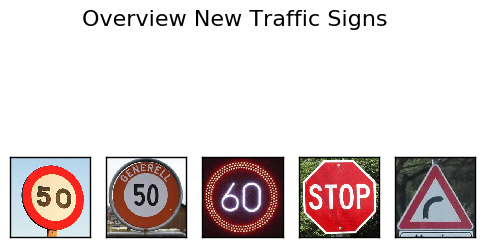

In [9]:
### Load the images and plot them here.
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

filenames = ["local-traffic-signs/img1.png", "local-traffic-signs/img2.png", "local-traffic-signs/img3.png", 
             "local-traffic-signs/img4.png", "local-traffic-signs/img5.png"]

# Create an overview of trafic sign classes and store them in list
fig = plt.figure()
fig.suptitle('Overview New Traffic Signs', fontsize=16)
pltRows = 1
pltCols = 5

new_traffic_signs = []

for el, filename in enumerate(filenames):
    img = mpimage.imread(filename)
    plt.subplot(pltRows, pltCols, el + 1)
    fig = plt.imshow(img, interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    # Resize images to 32x32 and add to list
    img_uint8 = (img * 255.)
    img_uint8 = img_uint8.astype(np.uint8)
    new_traffic_signs.append(cv2.resize(img_uint8, (32, 32)))

plt.show()

# Set labels for new traffic signs (50, 50, 60, stop, dangerous curve to the right)
new_traffic_signs_labels = [2, 2, 3, 14, 20]

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [10]:
### Run the predictions here.

# Preprocess image data and convert to np array
pre_processed_images = np.asarray([pre_process_image(img) for img in new_traffic_signs])

# Define new metric for softmax prediciton
prediction = tf.nn.softmax(logits)

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('classifier.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    s_max, test_accuracy = sess.run([prediction, accuracy_operation],
                                    feed_dict={x: pre_processed_images, y: new_traffic_signs_labels, keep_prob: 1.0})

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [11]:
### Visualize the softmax probabilities here.
print("Accuracy on new images is = {:.3f}".format(test_accuracy))

Accuracy on new images is = 0.600


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [12]:
import csv

with open("signnames.csv", 'r') as f:
    reader = csv.reader(f)
    sign_names = list(reader)
    sign_names = np.asarray(sign_names[1:])
    
def get_sign_name(label):
    return sign_names[label, :][1]

with tf.Session() as sess:
    top3_pred = sess.run(tf.nn.top_k(tf.constant(s_max), k=5))

for ground_truth, predition, probability in zip(new_traffic_signs_labels, top3_pred[1], top3_pred[0]):
    print("\"{}\" was classified as:".format(get_sign_name(ground_truth)))
    for ind in range(len(predition)):
        print("\t\t{}:\t\"{}\" with {}".format(ind, get_sign_name(predition[ind]), probability[ind]))

"Speed limit (50km/h)" was classified as:
		0:	"No passing for vechiles over 3.5 metric tons" with 0.9613198637962341
		1:	"Speed limit (80km/h)" with 0.03682996705174446
		2:	"Road work" with 0.0005815436015836895
		3:	"Yield" with 0.00027485136524774134
		4:	"Keep right" with 0.00020541821140795946
"Speed limit (50km/h)" was classified as:
		0:	"Speed limit (50km/h)" with 0.9773553609848022
		1:	"Speed limit (120km/h)" with 0.0035697005223482847
		2:	"Speed limit (30km/h)" with 0.0021028572227805853
		3:	"Beware of ice/snow" with 0.0020692339166998863
		4:	"Double curve" with 0.0017888855654746294
"Speed limit (60km/h)" was classified as:
		0:	"Speed limit (120km/h)" with 0.7417752742767334
		1:	"Roundabout mandatory" with 0.07027485221624374
		2:	"Speed limit (50km/h)" with 0.06337564438581467
		3:	"Keep left" with 0.05880540981888771
		4:	"Speed limit (100km/h)" with 0.02580646239221096
"Stop" was classified as:
		0:	"Stop" with 0.9995412826538086
		1:	"Road work" with 7.3420509579

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [13]:
### The file was stored and add to the repository as Traffic_Sign_Classifier.html.